# Scowl Simulated Deployment

The objective of this notebook is to:
1. Define the goals of the simulation run
2. Declare the methods of running the simulation
3. Visualize the simulation parameters
4. Run the simulations
5. Process the log data
6. Visualize the results

## What is the scope of the simulation?

1. Confirm the simulation parameters
    1. `Peer` mix (generator, consumer, superpeer/storage)
    2. Supply/Demand ratio
    3. `Peer` to `Tracker` network latency
    
2. The evaluation should answer:
    1. How many peers were rebalanced (independant variable) and how fast was the tracker able to rebalance its peers (dependant variable – in Hz)?
    2. What was the limiting resource? (e.g., network, cpu, memory, etc.)
    3. At what scale of peers did the limiting factor occur?
    4. How long was the average peer "starved" for electricity?
    5. When demand exceeded supply, did a black out occur?
    6. When should the system be sharded?
    7. When the network partitioned, did peers operating in SOC mode cause a black out in their region?
    8. *Stretch Goal* How small of a partition can the grid operate under?

# Simulation "Run Sheet"

The simulation should have (2) main parts:
1. **Electrical stress test under a healthy network** – There are imbalances between supply and demand, but the network remains up. `Trackers` attempt to pair `Consumers` with `Generators` that have additional capacity, the goal is to re-build the *ephemeral distribution trees* as fast as possible, so that `Consumer` starvation is minimized.
2. **Electrical stress test under a partitioned network** – Communication between the tracker and the peers is broken. Each `Consumer` is operating as a self optimizing consumer (soc). Each `Generator` is a self-optimizing generator (sog). `Generators` can **only** warn SOCs of an impending black out by sending a `capacity_low` rpc to their partition. This is analagous to real-world electricity consumers feeling the voltage sag of a brown-out, in advance of a black out. The warned consumers respond by self-imposing a call to `DemandResponse()`, until the `Generator` unchokes them <sup>1</sup>. The key metric here is how many `capacity_low` messages are sent, and how much *deferred consumption* consumers experience (i.e., this messaged in time and kWhs).

The energy mix will be based on the current the energy mix of New York State, and renewables will experience the same fluctations. The same "day" will be simulated for both the healthy network day (scowl) and the partitioned network day (soc/sog).

***
<sup>1</sup> This behaviour mimics the TCP congestion control algorithm, with a similar expectation that backing off demand will result in data (electricity) flowing again.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Electricity Generation Mix NY State (2020)

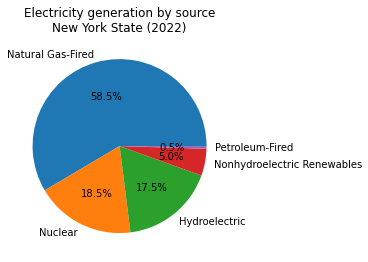

In [3]:
generation = pd.read_csv("data/ny_elec_gen_by_source_july_2022.csv", names=['category','mwh'], skiprows=5)
generation['portion'] = generation.mwh / (generation.mwh.sum()*len(generation))
generation.sort_values('mwh', ascending=False, inplace=True)

plt.pie(np.round(generation.portion*100,1), labels=generation.category,autopct='%.1f%%')
plt.title("Electricity generation by source\nNew York State (2022)")
plt.show()